# Aprendizado Profundo

# Processamento dos dados

# Redes Generativas Adversárias

# Caso de uso

In [1]:
var = """
TODO: 
- Leitura e apresentação dos dados
- Mostrar dados originais (2012 Apenas)
- Mostrar imagem do mapa
- Análise estatística para modelagem com ARIMA
""" 

In [76]:
import pandas as pd
import importlib
import plotting as p
importlib.reload(p)
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

## Leitura e descrição dos dados

In [2]:
bikes = pd.read_csv('datasets/bike_sharing_2011to2019.csv', index_col=0)
bikes.head()

,date,hour,cnt
0,2011-01-01,0,16
1,2011-01-01,1,40
2,2011-01-01,2,32
3,2011-01-01,3,13
4,2011-01-01,4,1


In [6]:
import numpy as np

In [7]:
for i in range(10):
    a = np.random.uniform(size=78888)
    a = a.reshape(78888//24, 24, 1)
    np.save("datasets/generated/synt_{}.npy".format(i), a)

In [5]:
bikes['cnt'].describe()

count    78888.000000
mean       329.480884
std        337.722508
min          0.000000
25%         59.000000
50%        226.000000
75%        487.000000
max       2037.000000
Name: cnt, dtype: float64

TODO: Breve explicação das colunas

In [13]:
lista_datas = p.get_list_dates(data_size=bikes.shape[0], year=2011, month=1, day=1)

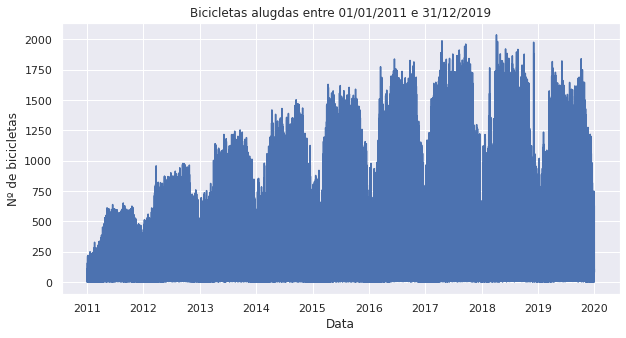

In [9]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(lista_datas, bikes['cnt'])
ax.set_xlabel("Data")
ax.set_ylabel("Nº de bicicletas")
ax.set_title("Bicicletas alugdas entre 01/01/2011 e 31/12/2019");

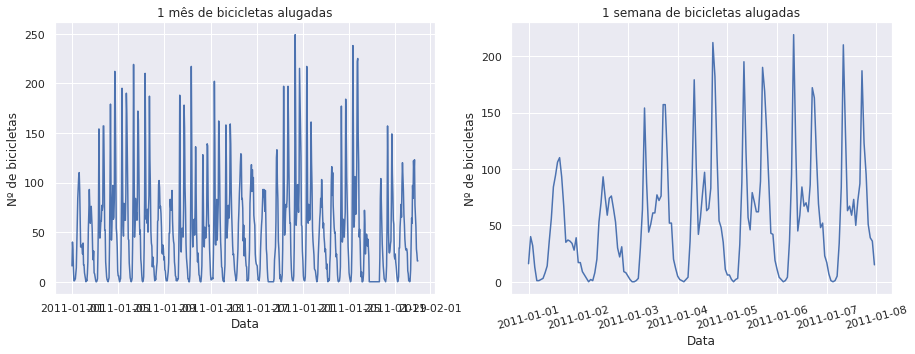

In [26]:
fig, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[0].plot(lista_datas[:30*24], bikes['cnt'].iloc[:30*24])
ax[0].set_xlabel("Data")
ax[0].set_ylabel("Nº de bicicletas")
ax[0].set_title("1 mês de bicicletas alugadas");
plt.xticks(rotation=15);
ax[1].plot(lista_datas[:7*24], bikes['cnt'].iloc[:7*24])
ax[1].set_xlabel("Data")
ax[1].set_ylabel("Nº de bicicletas")
ax[1].set_title("1 semana de bicicletas alugadas");
plt.xticks(rotation=15);

## Características esperadas

In [31]:
real_data = bikes['cnt'].values.reshape(bikes.shape[0]//24, 24)
df_real = p.get_df(list_dates=lista_datas, data=bikes[['cnt']].values, timesteps=24)
lista_cnt = [p.get_count(df_real,w,24, column='ts')['cnt_0'] for w in range(7)]

In [34]:
df_real

,date,cnt_0,wk,ts
0,2011-01-01 00:00:00,16,5,0
1,2011-01-01 01:00:00,40,5,1
2,2011-01-01 02:00:00,32,5,2
3,2011-01-01 03:00:00,13,5,3
4,2011-01-01 04:00:00,1,5,4
...,...,...,...,...
78883,2019-12-31 19:00:00,180,1,19
78884,2019-12-31 20:00:00,135,1,20
78885,2019-12-31 21:00:00,111,1,21
78886,2019-12-31 22:00:00,80,1,22


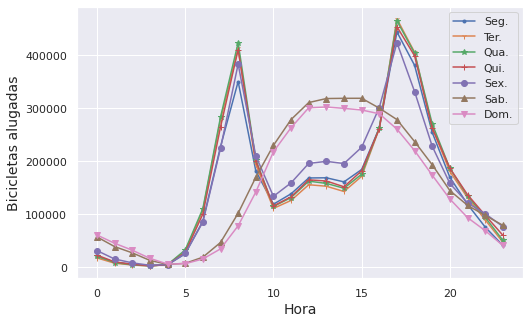

In [5]:
p.plot_sum_real(list_cnt_real=lista_cnt, list_dates=lista_datas)
plt.show()

In [9]:
import glob

In [11]:
path_lista_fakes = glob.glob('datasets/generated/*.npy')
lista_fakes = [np.load(a) for a in path_lista_fakes]

In [48]:
lista_weeks = p.get_list_wks(path_lista_fakes, None, lista_datas, timestep=24)

Done 0!
Done 2!
Done 4!
Done 6!
Done 8!


In [52]:
a = np.array(lista_weeks)

In [69]:
somas = a.mean(axis=0)

In [68]:
len(a[:, 0])

10

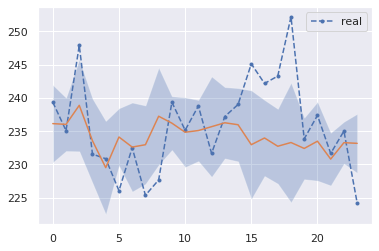

In [77]:
p.plot_compare_sum(a[0], somas, a.std(axis=0))

# Modelagem com o ARIMA

- Verificar se é estacionária
- Aplicar ajustes, se for necessário

In [5]:
from pmdarima.arima.stationarity import ADFTest
import pmdarima as pm

In [34]:
adf_test = ADFTest(alpha=0.05)
p_value, dif = adf_test.should_diff(bikes['cnt'].values)
print(p_value, dif)

0.01 False


In [3]:
train = bikes['cnt'].iloc[:365*24].values

In [12]:
pm_auto = pm.auto_arima(train, seasonal=True, maxiter=1, start_p=2, max_p=3, start_q=2, max_q=3, stationary=True, m=7)

In [13]:
pm_auto.seasonal_order

(0, 0, 1, 7)

## Treinamento

## Avaliação